# Voiced and Unvoiced Classifier Linear Prediction Coefficients


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
torch.manual_seed(1)
import librosa.display, librosa
import scipy


## Auto Correlation Function

In [5]:
def Autocor(signal, k):

    if k == 0:
        return np.sum(signal**2)
    else:
        return np.sum(signal[k:]*signal[:-k])

## Load Data

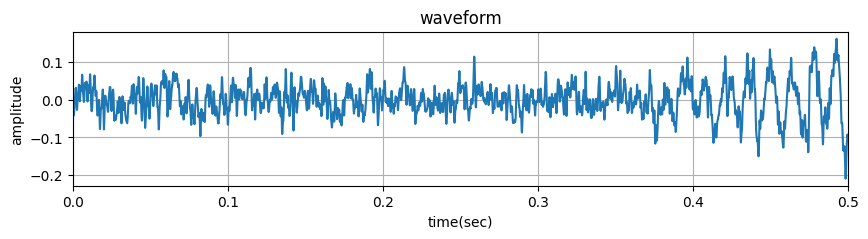

In [6]:
VOICED_FILE = os.path.join('data','drop.wav')
UNVOICED_FILE = os.path.join('data','wisper.wav')
def load_audio(file):
    sig, sr = librosa.load(file)
    signal = sig[9000:14000]
    return signal
voiced_signal = load_audio(VOICED_FILE)
unvoiced_signal = load_audio(UNVOICED_FILE)
t_axis = np.linspace(0,0.5,5000)
plt.figure(figsize = (10,2))
plt.ylabel('amplitude')
plt.title('waveform')
plt.xlabel('time(sec)')
plt.grid(True)
plt.xlim(0,0.5)
plt.plot(t_axis,unvoiced_signal)

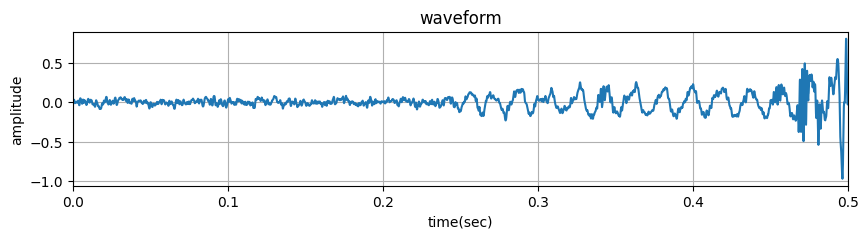

In [7]:
t_axis = np.linspace(0,0.5,5000)
plt.figure(figsize = (10,2))
plt.ylabel('amplitude')
plt.title('waveform')
plt.xlabel('time(sec)')
plt.grid(True)
plt.xlim(0,0.5)
plt.plot(t_axis,voiced_signal)

## Preprocessing

In [8]:
from scipy.linalg import solve_toeplitz, toeplitz

def preprocess(w_sig,p):
    r_list = [Autocor(w_sig,i) for i in range(p)]
    b_list = [Autocor(w_sig,i) for i in range(1,p+1)]
    LPC = solve_toeplitz((r_list,r_list),b_list)
    return LPC

## Get Prediction and Residual signal using Linear Prediction

### Hamming Window
### Window Length is 256
### Overlap is 50%

In [9]:
def residual(windowed_signal, p):
    
    LPC = preprocess(windowed_signal,p)
    length = len(windowed_signal)
    prediction = np.zeros((length))
    win_sig = np.pad(windowed_signal, p)[:-p]
    for k in range(length):
        prediction[k] = np.sum(win_sig[k:k+p][::-1]*LPC)
    error = windowed_signal - prediction
    return prediction, error

In [10]:
def prediction(signal, window, p, overlap = 0.5):
    
    # Zeropadding
    shift = int(len(window)*overlap)
    if len(signal) % shift != 0:                    
        pad = np.zeros(shift - (len(signal) % shift))  
        new_signal = np.append(signal, pad)                  
    else:
        new_signal = signal
    index = (len(new_signal) // shift) -1 
    

    whole_prediction = np.zeros((len(new_signal)),dtype = np.float64)
    whole_error = np.zeros((len(new_signal)),dtype = np.float64)
    
    for i in range(index):
        win_sig = new_signal[i*shift:i*shift+len(window)]*window #windowing
        prediction, error = residual(win_sig, p)
        whole_prediction[i*shift:i*shift+len(window)] += prediction
        whole_error[i*shift:i*shift+len(window)] += error
    
    return whole_prediction, whole_error

In [11]:
window = np.hamming(256)
pred,err = prediction(voiced_signal, window, 32)

In [12]:
def plot_PE(signal, whole_pred, whole_error,sr, start, end, error = False):
    
    whole_pred = whole_pred[:len(signal)]
    whole_error = whole_error[:len(signal)]
    t_axis = np.arange(len(signal))/sr
    
    plt.figure(figsize=(10,3))
    plt.grid(True)
    plt.xlabel('Time(sec)')
    plt.ylabel('Amplitude')
    plt.xlim(start, end)
    
    if not error:
        plt.plot(t_axis, signal)
        plt.plot(t_axis, whole_pred, '--')
        plt.legend(['original','prediction'])
        plt.title('Original signal & Prediction')
    else:
        plt.plot(t_axis, whole_error)
        plt.title('Residual Error')
        
    plt.show()

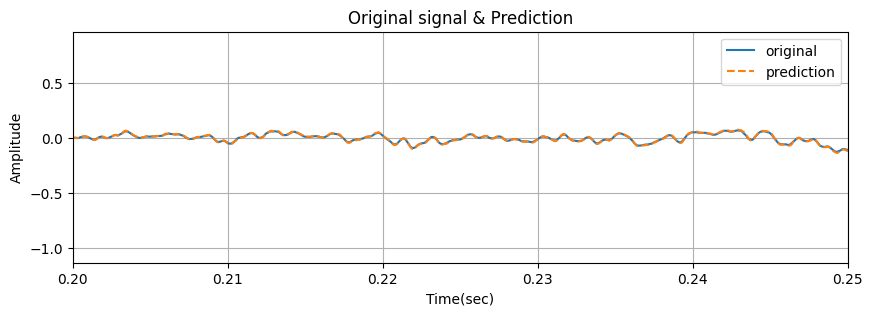

In [13]:
plot_PE(voiced_signal, pred, err, 10000, 0.2,0.25, False)

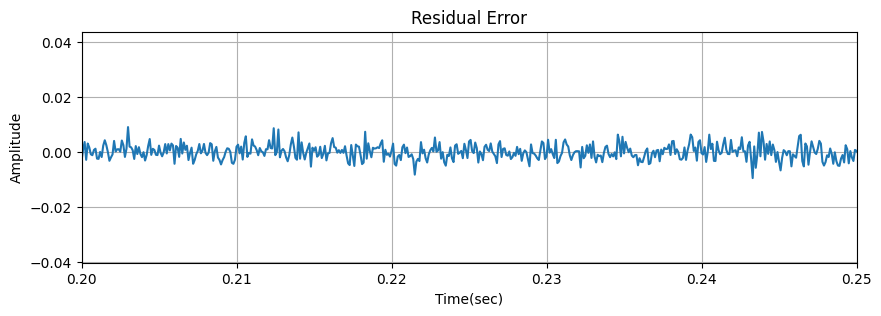

In [14]:
plot_PE(voiced_signal,pred, err, 10000, 0.2,0.25, True)

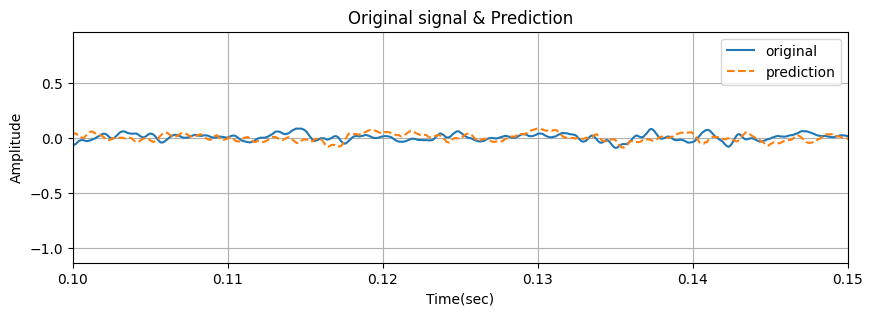

In [15]:
plot_PE(unvoiced_signal, pred, err, 10000, 0.1, 0.15, False)

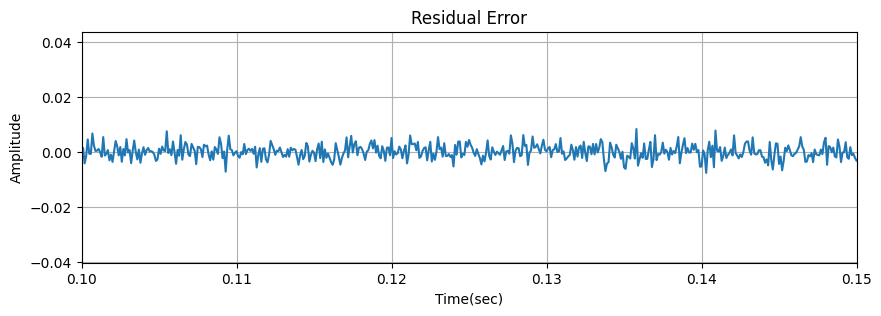

In [16]:
plot_PE(unvoiced_signal, pred, err, 10000, 0.1, 0.15, True)

In [17]:
def Lpcspectrum(signal, window, sr, *p_):
    
    plt.figure(figsize=(15,3),dpi = 100)
    win_sig = signal*window
    for i,p in enumerate(p_):
        plt.subplot(1,len(p_),i+1)
        LPC = preprocess(win_sig, p)
        LPC = np.insert(-LPC, 0, 1)
        value = 0 
        axis = np.linspace(0,sr/2,2048)
        w2,h2 = scipy.signal.freqz([0.04], LPC, worN=2048, fs = sr)
        S_fft = np.fft.rfft(win_sig,4096)
        plt.plot(axis,20*np.log(abs(S_fft[1:])),label = 'Signal Spectrum')  
        plt.plot(axis,20*np.log(abs(h2)),label = 'LPC Spectrum')
        plt.xlim(0,sr/2)
        plt.xlabel('frequency(Hz)')
        if i== 0:
            plt.ylabel('Magnitude(dB)')
        plt.title('order <{}>'.format(p))
        plt.legend()
        plt.grid(True)
    plt.show()

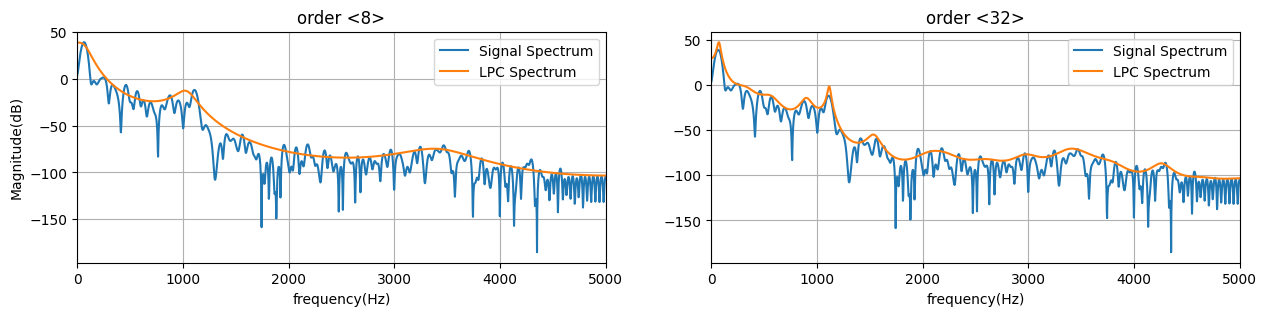

In [18]:
Lpcspectrum(voiced_signal[2400:2656], np.hamming(256),10000,8,32)

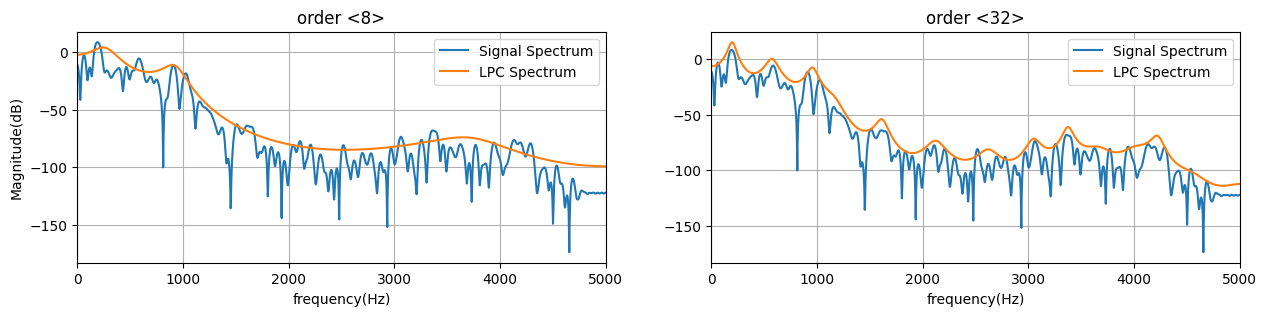

In [19]:
Lpcspectrum(unvoiced_signal[1100:1356], np.hamming(256),10000,8,32)